# Organizing Data


In [1]:
!wget -O hockeyfights.zip https://www.dropbox.com/sh/pmqpxc6bbckwd1j/AAAh5iUjDRiDEg6CEHHSbqDna?dl=0
!unzip hockeyfights.zip -d hockeyfights

--2023-05-13 20:15:33--  https://www.dropbox.com/sh/pmqpxc6bbckwd1j/AAAh5iUjDRiDEg6CEHHSbqDna?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/pmqpxc6bbckwd1j/AAAh5iUjDRiDEg6CEHHSbqDna [following]
--2023-05-13 20:15:33--  https://www.dropbox.com/sh/raw/pmqpxc6bbckwd1j/AAAh5iUjDRiDEg6CEHHSbqDna
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe732144ea711260c659241a04.dl.dropboxusercontent.com/zip_download_get/BfZ6K2loOhJQ2GvMyWgQYphkbDDDLdQB2P7_SGYqNDQN2APp0ysXkHAN8pXcQ9iysy1_7aYJ0sluSm70E1YpfIdEBxjLVkrVzZaalF_HdQUPHA# [following]
--2023-05-13 20:15:35--  https://ucbe732144ea711260c659241a04.dl.dropboxusercontent.com/zip_download_get/BfZ6K2loOhJQ2GvMyWgQYphkbDDDLdQB2P7_SGYqNDQN2APp0ysXkHAN8pXcQ9iysy1_7aYJ0sluSm70E1YpfIdEB

In [19]:
import os
import random
from os.path import isfile, join
from glob import glob as g
from shutil import copy, move

In [5]:
train_FI_dir = '/content/Hockey fights/train/FI'
train_NO_dir = '/content/Hockey fights/train/NO'
test_FI_dir = '/content/Hockey fights/test/FI'
test_NO_dir = '/content/Hockey fights/test/NO'
val_FI_dir = '/content/Hockey fights/validation/FI'
val_NO_dir = '/content/Hockey fights/validation/NO'
to_create = [
            train_FI_dir,
            train_NO_dir,
            test_FI_dir,
            test_NO_dir,
            val_FI_dir,
            val_NO_dir
]

for dir in to_create:
  os.makedirs(dir)

In [6]:
all_FI = g("/content/hockeyfights/fi*") # get directory of all fight movies
all_NO = g("/content/hockeyfights/no*")

In [7]:
train_num = 400
test_num = 80
val_num = 20

In [8]:
len(all_NO[train_num:-test_num])

20

In [9]:
for name in all_FI[:train_num]:
  copy(name , os.path.join(train_FI_dir , name.split('/')[-1])) # copy selected train movies to their new folder

for name in all_FI[train_num:-val_num]:
  copy(name , os.path.join(test_FI_dir , name.split('/')[-1]))

for name in all_FI[-val_num:]:
  copy(name , os.path.join(val_FI_dir , name.split('/')[-1]))



for name in all_NO[:train_num]:
  copy(name , os.path.join(train_NO_dir , name.split('/')[-1]))

for name in all_NO[train_num:-val_num]:
  copy(name , os.path.join(test_NO_dir , name.split('/')[-1]))

for name in all_NO[-val_num:]:
  copy(name , os.path.join(val_NO_dir , name.split('/')[-1]))

In [10]:
aa = g("/content/Hockey fights/validation/FI/*")
bb = g("/content/Hockey fights/test/FI/*")
cc = g("/content/Hockey fights/train/FI/*")

In [11]:
len(aa),len(bb),len(cc), 

(20, 80, 400)

# Extract Frames

In [12]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Cropping2D

In [13]:
def get_frames(path):
  cap = cv2.VideoCapture(path) # like an open file
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


  buffer = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8')) # array to hold each frame
  fc = 0
  ret = True # true if the current frame is available
  while (fc < frameCount  and ret):
      ret, image = cap.read()
      buffer[fc] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      fc += 1
  cap.release()
  return buffer

In [14]:
fi_buffer = get_frames("/content/Hockey fights/train/FI/fi100_xvid.avi")
no_buffer = get_frames("/content/Hockey fights/train/NO/no121_xvid.avi")

In [15]:
no_buffer.shape

(41, 288, 360, 3)

## Frame Difference

In [16]:
frame_per_video = 10

In [ ]:
def get_frame_difference(path, plot = False):
  cap = cv2.VideoCapture(path)
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  buffer = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
  fc = 0
  ret = True # true if the frame is available
  while (fc < frameCount  and ret):
      ret, image = cap.read()
      buffer[fc] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      fc += 1
  cap.release()
  # data augmentation
  buffer = Cropping2D((50,15))(buffer)

  dif = np.empty((10, 224, 224, 3))
  for i in range(frame_per_video):
    temp = cv2.absdiff(buffer[4*i+1].numpy(),buffer[4*i].numpy())
    temp = tf.keras.preprocessing.image.random_shift(temp, 0.2,0.2,row_axis=0,col_axis=1, channel_axis=2, fill_mode = 'constant', cval = 0.)
    if random.random()>0.8:
      temp = tf.image.transpose(temp)
    dif[i] =  tf.image.resize(temp, (224,224))

  if plot:
    return dif
  
  resnet_output = np.empty(resnet_output_shape)
  resnet_output = get_resnet_output(dif)

  return resnet_output

In [20]:
fi_dif = get_frame_difference("/content/Hockey fights/train/FI/fi100_xvid.avi", plot = True)
no_dif = get_frame_difference("/content/Hockey fights/train/NO/no121_xvid.avi", plot = True)

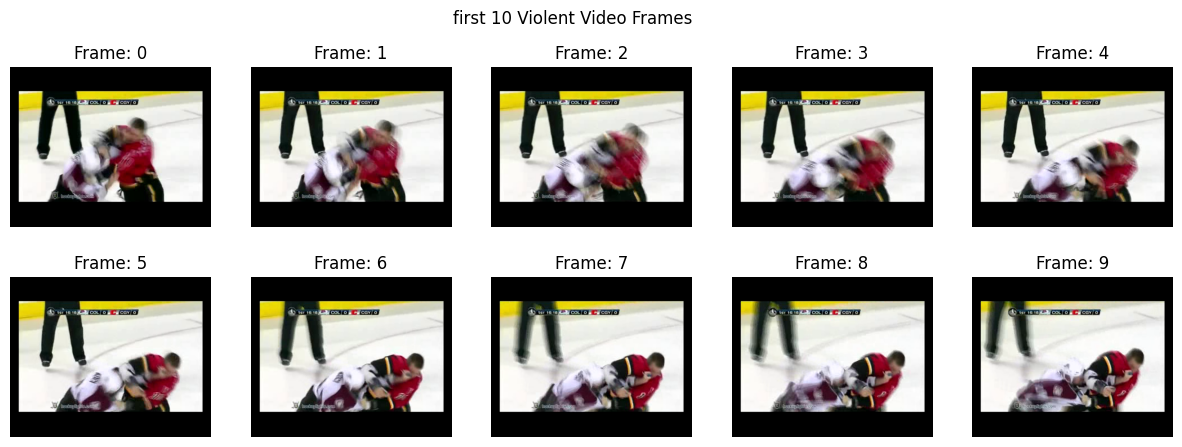

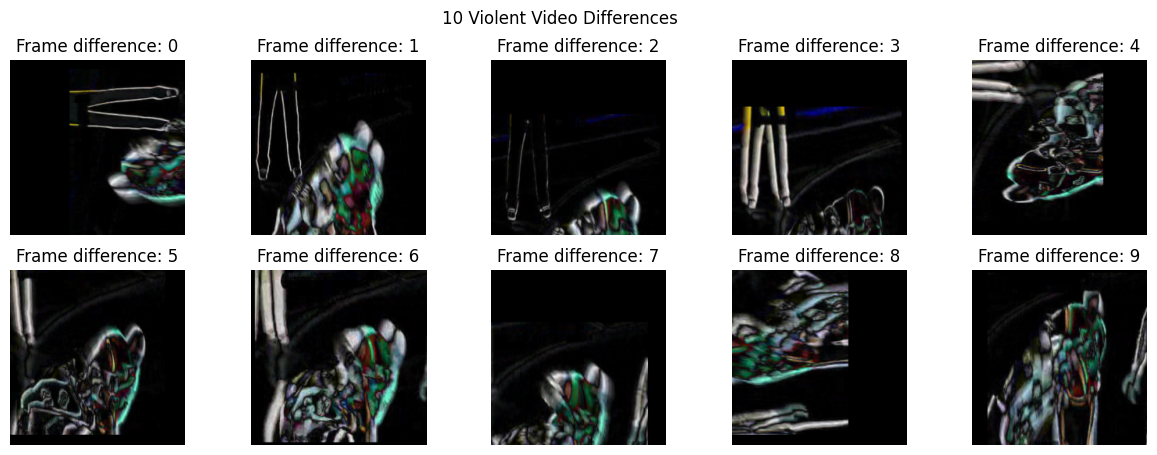

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
fig.suptitle('first 10 Violent Video Frames')
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(fi_buffer[i*5+j])
    ax[i, j].axis('off')
    ax[i, j].set_title(f"Frame: {i*5+j}")

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
fig.suptitle('10 Violent Video Differences')
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(fi_dif[i*5+j]/fi_dif[i*5+j].max())
    ax[i, j].axis('off')
    ax[i, j].set_title(f"Frame difference: {i*5+j}")

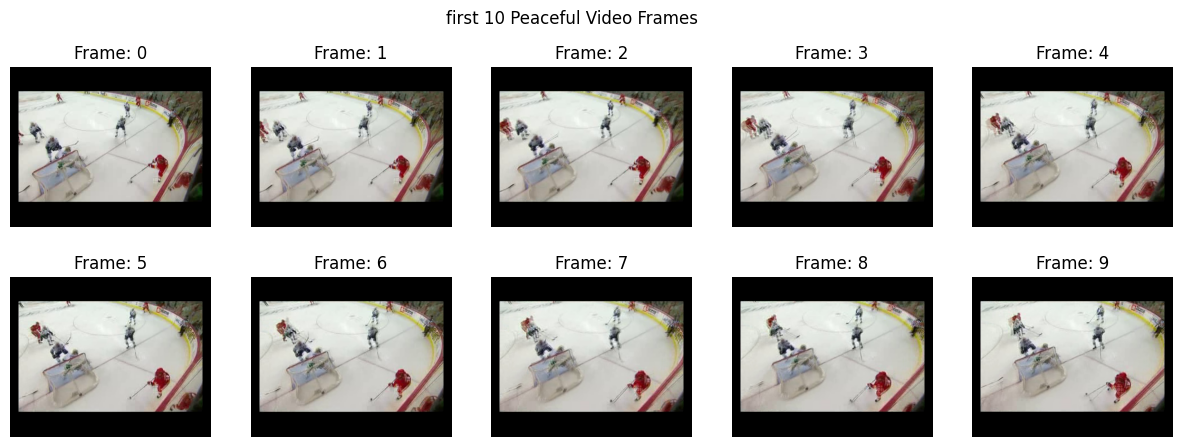

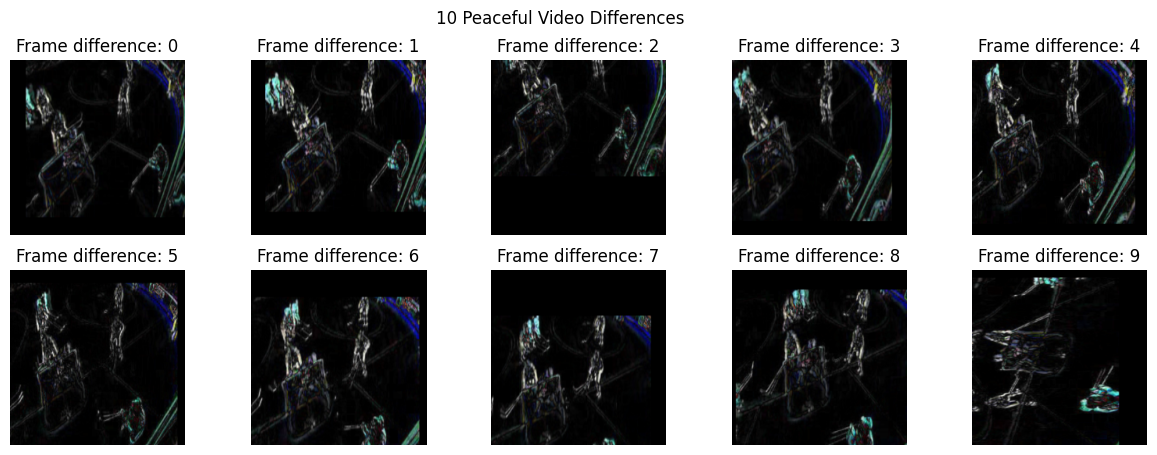

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
fig.suptitle('first 10 Peaceful Video Frames')
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(no_buffer[i*5+j])
    ax[i, j].axis('off')
    ax[i, j].set_title(f"Frame: {i*5+j}")

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
fig.suptitle('10 Peaceful Video Differences')
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(no_dif[i*5+j]/no_dif[i*5+j].max())
    ax[i, j].axis('off')
    ax[i, j].set_title(f"Frame difference: {i*5+j}")

# Creating Dataset

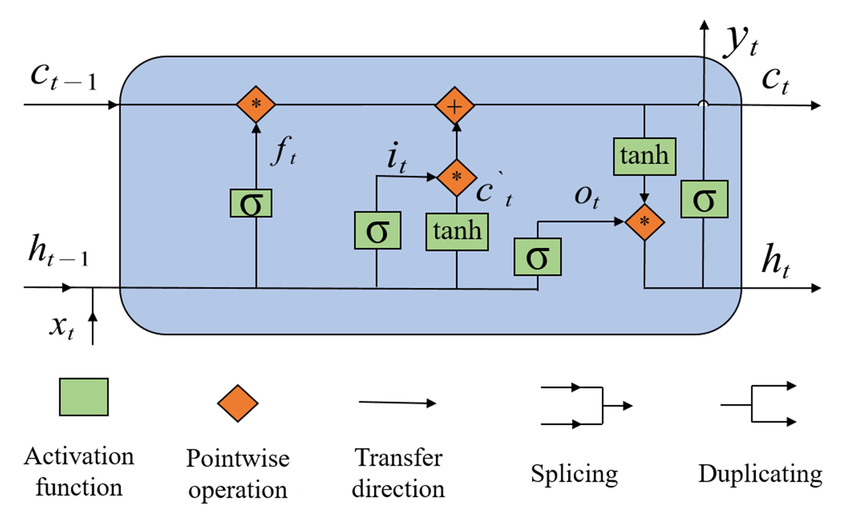

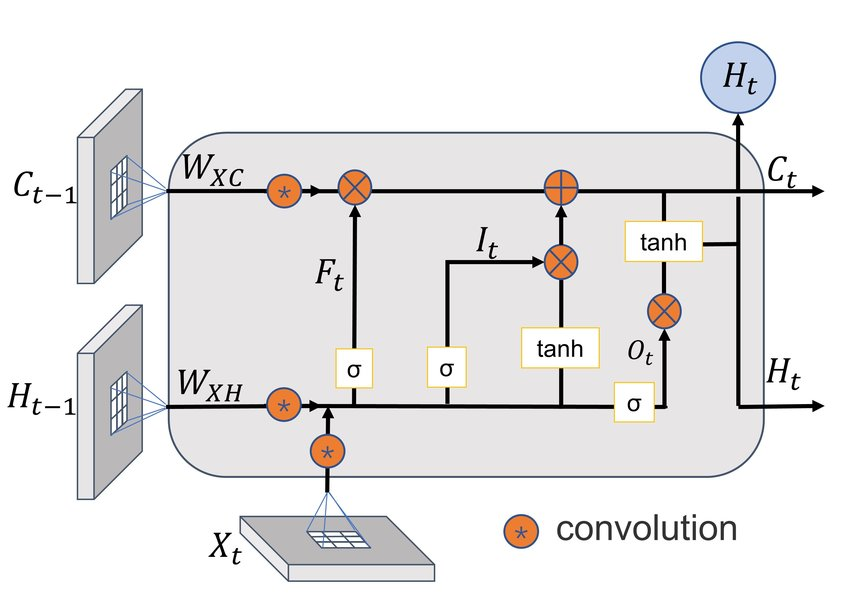

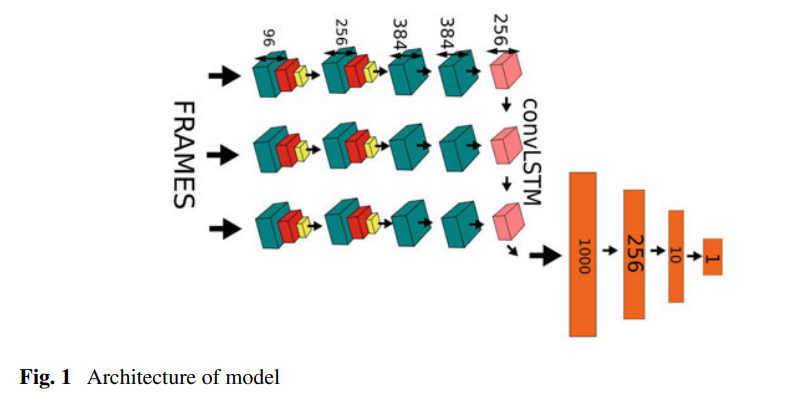

In [23]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, ConvLSTM2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.python.ops.numpy_ops import np_config

In [25]:
full_model = ResNet50(include_top = True)
full_model.trainable = False

102967424/102967424 [==============================] - 3s 0us/step


In [6]:
full_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [26]:
last_layer  = full_model.get_layer("conv5_block3_2_relu") # last cnn layer before FC
resnet_model = Model(inputs=full_model.input,
                             outputs=last_layer.output)


In [27]:
resnet_output_shape = (10, 7, 7, 512)

In [28]:
def get_resnet_output(dif):
  output = resnet_model.predict(dif, verbose = False)
  return output

In [31]:
train_dir = '/content/Hockey fights/train'
test_dir = '/content/Hockey fights/test'

In [32]:
class FrameGenerator:
  def __init__(self, path, training):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.training = training

  def get_files_and_class_names(self):
    
    if self.training:
      fi_video_paths = g('/content/Hockey fights/train/FI/*')
      no_video_paths = g('/content/Hockey fights/train/NO/*')
      video_paths = fi_video_paths + no_video_paths
      
      fi_classes = [1]*train_num
      no_classes = [0]*train_num
      classes = fi_classes + no_classes
    else:
      fi_video_paths = g('/content/Hockey fights/test/FI/*')
      no_video_paths = g('/content/Hockey fights/test/NO/*')
      video_paths = fi_video_paths + no_video_paths

      fi_classes = [1]*test_num
      no_classes = [0]*test_num
      classes = fi_classes + no_classes

    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes)) # pairs all videos to their corresponding label

    random.shuffle(pairs)

    for Path, name in pairs:
      video_frames = get_frame_difference(Path) 
      label = name
      yield video_frames, label

In [10]:
list(zip([1,2,3],[10,20,30]))

[(1, 10), (2, 20), (3, 30)]

In [33]:
output_signature = (tf.TensorSpec(shape = (resnet_output_shape), dtype = tf.float32), # output_signature determintes shape and dtype for input & output
                    tf.TensorSpec(shape = (), dtype = tf.int16))
# Create the validation set
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_dir, training=True),
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_dir, training=False),
                                        output_signature = output_signature)

In [34]:
train_ds = train_ds.batch(2)
test_ds = test_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Shape of training set of frames: (2, 10, 7, 7, 512)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 7, 7, 512)
Shape of validation labels: (2,)


# building model

In [35]:
model = Sequential()
# model.add(tf.keras.layers.Rescaling(1./255)
model.add(ConvLSTM2D(filters=256, kernel_size=(3, 3),
                   input_shape=resnet_output_shape,
                   return_sequences=False, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation = 'relu', kernel_initializer="glorot_normal"))
model.add(Dense(256, activation = 'relu', kernel_initializer="glorot_normal"))
model.add(Dense(10, activation = 'relu', kernel_initializer="glorot_normal"))
model.add(Dense(1, activation = 'sigmoid', kernel_initializer="glorot_normal"))


In [36]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-4,
    decay_steps=400,
    decay_rate=0.5)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 5, 5, 256)         7078912   
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 256)        1024      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 1000)              6401000   
                                                                 
 dense_1 (Dense)             (None, 256)               256256    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                        

In [37]:
history = model.fit(train_ds, 
          epochs = 10,
          validation_data = test_ds,
callbacks = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'))

Epoch 1/10
400/400 [==============================] - 310s 751ms/step - loss: 0.4213 - accuracy: 0.8400 - val_loss: 0.2003 - val_accuracy: 0.9312
Epoch 2/10
400/400 [==============================] - 295s 738ms/step - loss: 0.2318 - accuracy: 0.9225 - val_loss: 0.2752 - val_accuracy: 0.9000
Epoch 3/10
400/400 [==============================] - 330s 825ms/step - loss: 0.1700 - accuracy: 0.9350 - val_loss: 0.2492 - val_accuracy: 0.9125
Epoch 4/10
400/400 [==============================] - 297s 744ms/step - loss: 0.1397 - accuracy: 0.9438 - val_loss: 0.2109 - val_accuracy: 0.9375
Epoch 5/10
400/400 [==============================] - 300s 751ms/step - loss: 0.1059 - accuracy: 0.9575 - val_loss: 0.1621 - val_accuracy: 0.9312
Epoch 6/10
400/400 [==============================] - 293s 733ms/step - loss: 0.0907 - accuracy: 0.9700 - val_loss: 0.2679 - val_accuracy: 0.8813
Epoch 7/10
400/400 [==============================] - 292s 729ms/step - loss: 0.0939 - accuracy: 0.9613 - val_loss: 0.2307 -

# Saving and loading model


## save

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('/content/saved_model/saved_model')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av '/content/saved_model/saved_model' '/content/drive/MyDrive'

'/content/saved_model/saved_model' -> '/content/drive/MyDrive/saved_model'
'/content/saved_model/saved_model/variables' -> '/content/drive/MyDrive/saved_model/variables'
'/content/saved_model/saved_model/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/saved_model/variables/variables.data-00000-of-00001'
'/content/saved_model/saved_model/variables/variables.index' -> '/content/drive/MyDrive/saved_model/variables/variables.index'
'/content/saved_model/saved_model/assets' -> '/content/drive/MyDrive/saved_model/assets'
'/content/saved_model/saved_model/fingerprint.pb' -> '/content/drive/MyDrive/saved_model/fingerprint.pb'
'/content/saved_model/saved_model/saved_model.pb' -> '/content/drive/MyDrive/saved_model/saved_model.pb'
'/content/saved_model/saved_model/keras_metadata.pb' -> '/content/drive/MyDrive/saved_model/keras_metadata.pb'


## load

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model')

# Check its architecture
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 5, 5, 256)        7078912   
                                                                 
 batch_normalization_11 (Bat  (None, 5, 5, 256)        1024      
 chNormalization)                                                
                                                                 
 flatten_11 (Flatten)        (None, 6400)              0         
                                                                 
 dense_44 (Dense)            (None, 1000)              6401000   
                                                                 
 dense_45 (Dense)            (None, 256)               256256    
                                                                 
 dense_46 (Dense)            (None, 10)                2570      
                                                     

# Evaluation


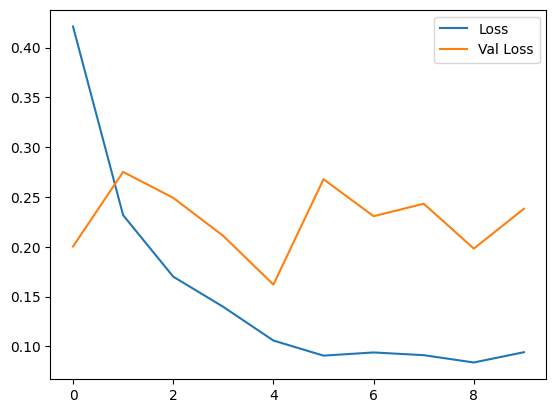

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val Loss'])

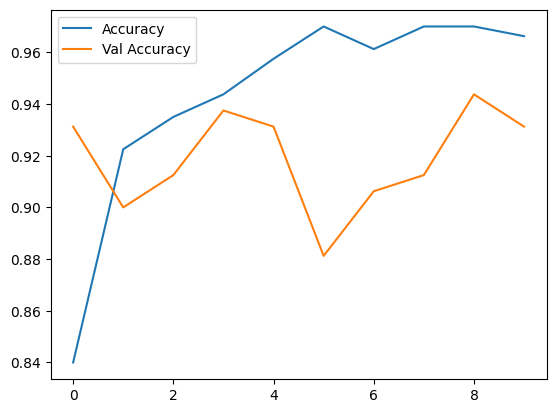

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'])

In [51]:
sample_test_FI_path = g("/content/Hockey fights/test/FI/*")
sample_test_NO_path = g("/content/Hockey fights/test/NO/*")

In [52]:
y_preds = []
for sample_path in sample_test_FI_path:
  sample = get_frame_difference(sample_path)
  sample = np.expand_dims(sample, axis = 0)
  y_preds.append(model.predict(sample, verbose = 0).round())


for sample_path in sample_test_NO_path:
  sample = get_frame_difference(sample_path)
  sample = np.expand_dims(sample, axis = 0)
  y_preds.append(model.predict(sample, verbose = 0).round())


y_preds = [y[0][0] for y in y_preds]
y_true = [1]*80 + [0]*80

In [53]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(y_true, y_preds)
precision  = precision_score(y_true, y_preds)
f1_Score = f1_score(y_true, y_preds)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')

Accuracy is 0.95625
Presicion is 0.9620253164556962
F1 score is 0.9559748427672956


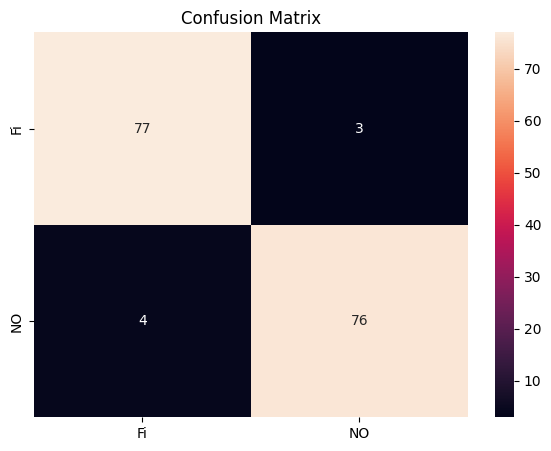

In [54]:
cf_matrix = confusion_matrix(y_true, y_preds)
df_cm = pd.DataFrame(cf_matrix , index = ['Fi', 'NO'],
                     columns = ['Fi', 'NO'])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix');

## Validation set

In [55]:
sample_val_FI_path = g("/content/Hockey fights/validation/FI/*")
sample_val_NO_path = g("/content/Hockey fights/validation/NO/*")

In [56]:
y_preds = []
for sample_path in sample_val_FI_path:
  sample = get_frame_difference(sample_path)
  sample = np.expand_dims(sample, axis = 0)
  y_preds.append(model.predict(sample, verbose = 0))

n_correct = 0
for i in range(len(y_preds)):
  if y_preds[i][0][0].round() == 1.0:
    n_correct += 1
    
y_preds = []
for sample_path in sample_val_NO_path:
  sample = get_frame_difference(sample_path)
  sample = np.expand_dims(sample, axis = 0)
  y_preds.append(model.predict(sample, verbose = 0))

for i in range(len(y_preds)):
  if y_preds[i][0][0].round() == 0.0:
    n_correct += 1

In [57]:
print(f'Validation accuracy is: {n_correct/val_num/2*100}%')

Validation accuracy is: 90.0%


https://www.tensorflow.org/tutorials/load_data/video